In [5]:
import numpy as np
import pandas as pd
from scipy import stats, linalg
from scipy.interpolate import UnivariateSpline
from scipy.optimize import minimize
from joblib import Parallel, delayed
import scanpy as sc
import time
from scipy import integrate
from scipy.signal import find_peaks
from collections import namedtuple
import pandas as pd

In [6]:
import importlib

In [7]:
!pwd

/n/fs/ragr-data/users/hirak/Workspace/copulacci/notebook/tutorial


In [8]:
xen_data = sc.read_h5ad("/n/fs/ragr-data/users/hz7140/external/0111-copulacci/xenium.h5ad")
cod_data = sc.read_h5ad("/n/fs/ragr-data/users/hz7140/external/0111-copulacci/codex.h5ad")

/n/fs/ragr-data/users/hirak/environments/mambaforge/envs/neuronic_env/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
xen_data

AnnData object with n_obs × n_vars = 204650 × 476
    obsm: 'spatial'

In [10]:
cod_data

AnnData object with n_obs × n_vars = 204650 × 25
    obsm: 'spatial'

In [11]:
import standalone_copula

In [12]:
importlib.reload(standalone_copula)

<module 'standalone_copula' from '/n/fs/ragr-data/users/hirak/Workspace/copulacci/notebook/tutorial/standalone_copula.py'>

In [13]:
copula_params = standalone_copula.CopulaParams()
opt_params = standalone_copula.OptParams()

In [16]:
xen_array = xen_data.to_df().sum(1).values
cod_array = cod_data.to_df().sum(1).values

In [17]:
xen_genes = xen_data.to_df().columns
cod_genes = cod_data.to_df().columns

In [18]:
xen_counts = xen_data.to_df().values
cod_counts = cod_data.to_df().values

In [19]:
# Define the gene pairs
xen_gene_count = xen_counts.shape[1]
cod_gene_count = cod_counts.shape[1]
gene_pairs = [(i, j) for i in range(xen_gene_count) for j in range(cod_gene_count)]



In [20]:
from scipy.stats import spearmanr

# Normalize rows for xen_counts and cod_counts
epsilon = 1e-10

# Normalize rows with protection against zero division
xen_counts_normalized = xen_counts / (xen_counts.sum(axis=1, keepdims=True) + epsilon)
cod_counts_normalized = cod_counts / (cod_counts.sum(axis=1, keepdims=True) + epsilon)

In [21]:
fg = [g1 for (g1,g2) in gene_pairs]
sg = [g2 for (g1,g2) in gene_pairs]

In [22]:
spearman_results = Parallel(n_jobs=30, verbose=1)(
    delayed(spearmanr)(
        xen_counts_normalized[:, i],
        cod_counts_normalized[:, j]
    ) for (i, j) in gene_pairs
)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:    2.9s
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed:    5.5s
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed:    9.5s
[Parallel(n_jobs=30)]: Done 1190 tasks      | elapsed:   14.4s
[Parallel(n_jobs=30)]: Done 1740 tasks      | elapsed:   20.4s
[Parallel(n_jobs=30)]: Done 2390 tasks      | elapsed:   27.6s
[Parallel(n_jobs=30)]: Done 3140 tasks      | elapsed:   36.2s
[Parallel(n_jobs=30)]: Done 3990 tasks      | elapsed:   45.9s
[Parallel(n_jobs=30)]: Done 4940 tasks      | elapsed:   56.9s
[Parallel(n_jobs=30)]: Done 5990 tasks      | elapsed:  1.1min
[Parallel(n_jobs=30)]: Done 7140 tasks      | elapsed:  1.3min
[Parallel(n_jobs=30)]: Done 8390 tasks      | elapsed:  1.6min
[Parallel(n_jobs=30)]: Done 9740 tasks      | elapsed:  1.8min
[Parallel(n_jobs=30)]: Done 11190 tasks      | elapsed:  2.1min
[Parallel(n_jobs=30)]: Done 11900 out of 11

In [23]:
import pickle
df = pd.DataFrame(
    pickle.load(open('HZ_copula_quick.pkl','rb')),
    columns = ['rho_cop_stab','mean_x','mean_y','status']
)

In [24]:
rho_values = [result[0] for result in spearman_results]

In [25]:
df['fg_ind'] = fg
df['sg_ind'] = sg

In [26]:
gene_pair_names = pd.DataFrame(
    [(xen_gene, cod_gene) for xen_gene in xen_genes for cod_gene in cod_genes],
    columns=["xen_gene", "cod_gene"]
)

# Assuming df has the same length as gene_pairs
df["xen_gene"] = gene_pair_names["xen_gene"]
df["cod_gene"] = gene_pair_names["cod_gene"]

In [27]:
df['rho_sp'] = rho_values

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
rho_cop_matrix = df.pivot(index='xen_gene', columns='cod_gene', values='rho_cop_stab')

# Reshape data for rho_sp
rho_sp_matrix = df.pivot(index='xen_gene', columns='cod_gene', values='rho_sp')

<Axes: xlabel='cod_gene', ylabel='xen_gene'>

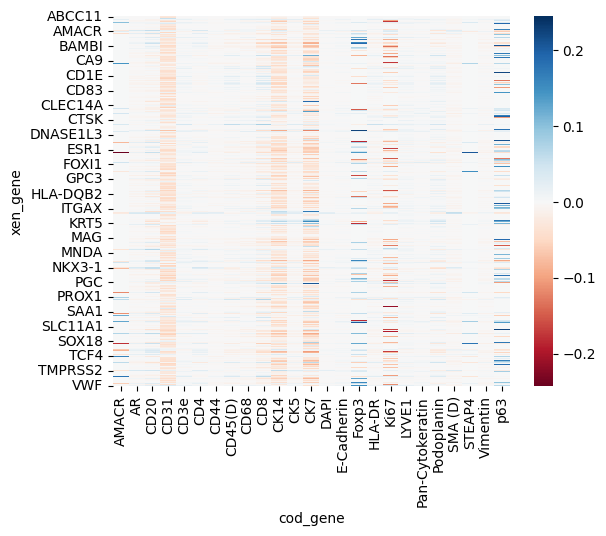

In [31]:
sns.heatmap(rho_cop_matrix, cmap='RdBu', center=0)

<Axes: xlabel='cod_gene', ylabel='xen_gene'>

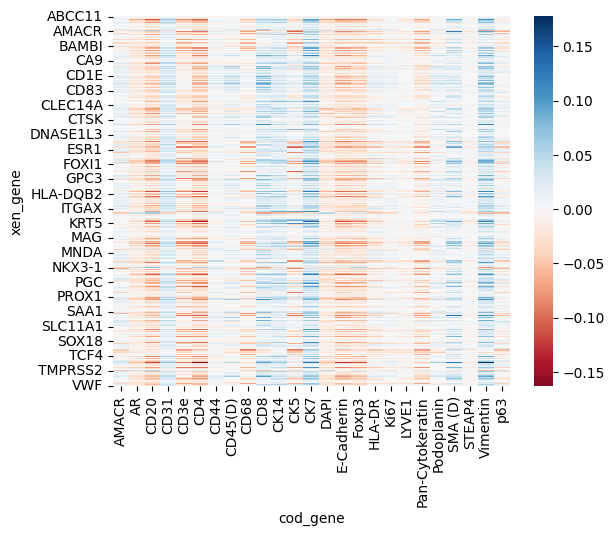

In [32]:
sns.heatmap(rho_sp_matrix, cmap='RdBu', center=0)

In [34]:
df_run = df.loc[df.status == 'copula']

In [38]:
df_run

,rho_cop_stab,mean_x,mean_y,status,fg_ind,sg_ind,xen_gene,cod_gene,rho_sp
100,0.000991,-4.564853,-2.218843,copula,4,0,ACTG2,DAPI,-0.070905
102,0.008919,-4.564853,-5.902835,copula,4,2,ACTG2,LYVE1,-0.028543
103,0.004955,-4.564853,-1.477024,copula,4,3,ACTG2,CD4,-0.106490
104,0.024775,-4.564853,-3.629874,copula,4,4,ACTG2,CK5,-0.044324
106,0.022793,-4.564853,-3.630578,copula,4,6,ACTG2,CD68,-0.054990
...,...,...,...,...,...,...,...,...,...
11815,0.002973,-4.607843,-2.434750,copula,472,15,VEGFA,CD3e,-0.069051
11818,-0.004955,-4.607843,-3.081368,copula,472,18,VEGFA,CD44,0.005284
11819,0.052523,-4.607843,-4.993749,copula,472,19,VEGFA,Foxp3,-0.040709
11820,0.030721,-4.607843,-3.917899,copula,472,20,VEGFA,CD20,-0.042357


array([[<Axes: title={'center': 'rho_cop_stab'}>,
        <Axes: title={'center': 'rho_sp'}>]], dtype=object)

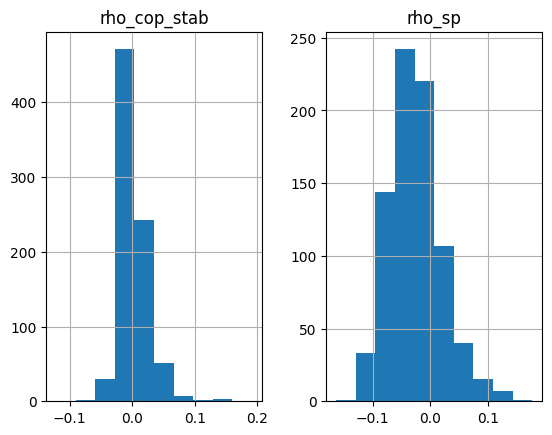

In [40]:
df.loc[df.status == 'copula'][['rho_cop_stab', 'rho_sp']].hist()

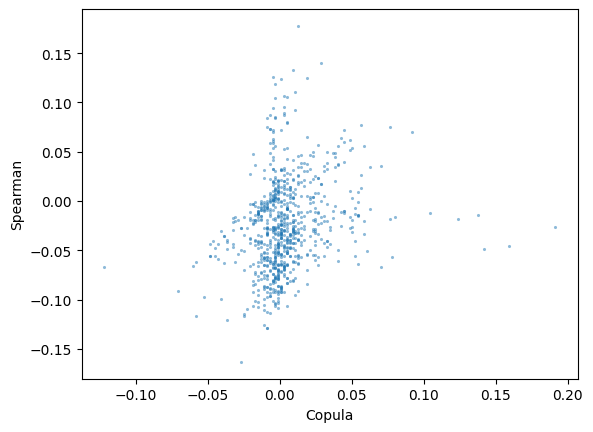

In [48]:
sns.scatterplot(
    data=  df.loc[df.status == 'copula'],
    y = 'rho_sp',
    x = 'rho_cop_stab',
    s = 5,
    lw = 0,
    alpha = 0.5
)
# plt.xlim(-0.25,0.25)
# plt.ylim(-0.25,0.25)
#plt.gca().set_aspect('equal')
plt.ylabel('Spearman')
plt.xlabel('Copula')
plt.show()

In [ ]:
result